### Automatic Feature Selection

- Adding more features makes all models more complex, and so increases the chance of overfitting. 
- When adding new features, or with high-dimensional datasets in general, it can be a good idea to reduce the number of features to only the most useful ones, and discard the rest. 
- This can lead to simpler models that generalize better. But how can you know how good each feature is? There are three basic strategies: *univariate statistics*, *model-based selection*, and *iterative selection*. 
- All of these methods are *supervised methods*, meaning they need the target for fitting the model. This means we need to split the data into training and test sets, and fit the feature selection only on the training part of the data.

#### Univariate Statistics

- In univariate statistics, we compute whether there is a statistically significant relationship between each feature and the target.
- Then the features that are related with the highest confidence are selected.
- In the case of classification, this is also known as analysis of variance (ANOVA)
- A key property of these tests is that they are univariate, meaning that they only consider each feature individually. 
- Univariate tests are often very fast to compute, and don’t require building a model.
- To use univariate feature selection in scikit-learn, you need to choose a test, usually either **f_classif (the default) for classification or f_regression for regression,** and a method to discard features based on the p-values determined in the test.
- The methods differ in how they compute this threshold, with the simplest ones being SelectKBest, which selects a fixed number k of features, and SelectPercentile, which selects a fixed percentage of features. 

In [11]:
# To make the task a bit harder, we’ll add some noninformative noise features to the data. 
# We expect the feature selection to be able to identify the features that are noninformative and remove them

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

In [6]:
cancer = load_breast_cancer()

# get deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
print("Shape of dataset: {}".format(cancer.data.shape))
# add noise features to the data
# the first 30 features are from the dataset, the next 50 are noise
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(
    X_w_noise, cancer.target, random_state=0, test_size=.5)
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

Shape of dataset: (569, 30)
X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


As you can see, the number of features was reduced from 80 to 40 (50 percent of the original number of features). We can find out which features have been selected using the **get_support method**, which returns a Boolean mask of the selected features

[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


Text(0.5,0,'Sample index')

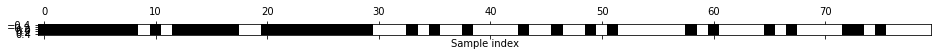

In [9]:
mask = select.get_support()
print(mask)
# visualize the mask -- black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")

In [12]:
from sklearn.linear_model import LogisticRegression

# transform test data
X_test_selected = select.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Score with all features: {:.3f}".format(lr.score(X_test, y_test)))
lr.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(lr.score(X_test_selected, y_test)))

Score with all features: 0.919
Score with only selected features: 0.912


#### Model-Based Feature Selection

- Model-based feature selection uses a supervised machine learning model to judge the importance of each feature, and keeps only the most important ones.
- The supervised model that is used for feature selection doesn’t need to be the same model that is used for the final supervised modeling. 
- The feature selection model needs to provide some measure of importance for each feature, so that they can be ranked by this measure.
- Decision trees and decision tree–based models provide a **feature_importances_** attribute, which directly encodes the importance of each feature.
- Linear models have coefficients, which can also be used to capture feature importances by considering the
absolute values.
- In contrast to univariate selection, model-based selection considers all features at once, and so can capture interactions (if the model can capture them). To use model-based feature selection, we need to use the
**SelectFromModel** transformer

- The SelectFromModel class selects all features that have an importance measure of the feature (as provided by the supervised model) greater than the provided threshold. 
- To get a comparable result to what we got with univariate feature selection, we used the median as a threshold, so that half of the features will be selected. 
- We use a random forest classifier with 100 trees to compute the feature importances. This is a quite complex model and much more powerful than using univariate tests. Now let’s actually fit the model

In [13]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42),threshold="median")
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


Text(0.5,0,'Sample index')

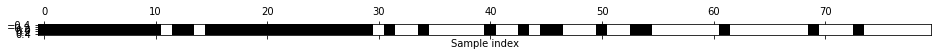

In [14]:
mask = select.get_support()
# visualize the mask -- black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")

In [15]:
# This time, all but two of the original features were selected. 
# Because we specified to select 40 features, some of the noise features are also selected.

X_test_l1 = select.transform(X_test)
score = LogisticRegression().fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.930


#### Iterative Feature Selection

- In univariate testing we used no model, while in model-based selection we used a single model to select features. 
- In iterative feature selection, a series of models are built,with varying numbers of features. There are two basic methods: starting with no features and adding features one by one until some stopping criterion is reached, or
starting with all features and removing features one by one until some stopping criterion is reached. 
- Because a series of models are built, these methods are much more computationally expensive than the methods we discussed previously. 
- One particular method of this kind is recursive feature elimination (RFE), which starts with all features, builds a model, and discards the least important feature according to the model. 
- Then a new model is built using all but the discarded feature, and so on until only a prespecified number of features are left. 
- For this to work, the model used for selection needs to provide some way to determine feature importance, as was the case for the model-based selection. 

Text(0.5,0,'Sample index')

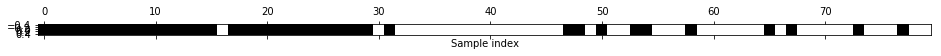

In [16]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=40)

select.fit(X_train, y_train)
# visualize the selected features:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")

- The feature selection got better compared to the univariate and model-based selection, but one feature was still missed. 
- Running this code also takes significantly longer than that for the model-based selection, because a random forest model is trained 40 times, once for each feature that is dropped.

In [17]:
X_train_rfe= select.transform(X_train)
X_test_rfe= select.transform(X_test)

score = LogisticRegression().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.930


We can also use the model used inside the RFE to make predictions. This uses only the feature set that was selected:

In [18]:
print("Test score: {:.3f}".format(select.score(X_test, y_test)))

Test score: 0.951


- Here, the performance of the random forest used inside the RFE is the same as that achieved by training a logistic regression model on top of the selected features.
- If you are unsure when selecting what to use as input to your machine learning algorithms, automatic feature selection can be quite helpful. 
- It is also great for reducing the amount of features needed—for example, to speed up prediction or to allow for
more interpretable models. 
- In most real-world cases, applying feature selection is unlikely to provide large gains in performance.